In [ ]:
# Remove this
#! pip install torch==2.3 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
! pip install --upgrade torch torchvision==0.15.0+cu118 --index-url https://download.pytorch.org/whl/cu118

#! pip install stacchip
#! pip install geopandas

! pip install contextily

In [1]:
import warnings

import geoarrow.pyarrow as ga
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pystac_client
import requests
import torch
import yaml
from box import Box

import stacchip.indexer
from stacchip.chipper import Chipper
from stacchip.indexer import Sentinel2Indexer
from torchvision.transforms import v2

import geopandas as gpd
import pandas as pd

from shapely.geometry import Polygon
import matplotlib.pyplot as plt

import math
import os
import random

import timm
import torch
import torch.nn.functional as F
from einops import rearrange, reduce, repeat
from torch import nn
from torchvision.transforms import v2

from src.backbone import Transformer
from src.factory import DynamicEmbedding
from src.utils import posemb_sincos_2d_with_gsd

torch.set_float32_matmul_precision("medium")
os.environ["TORCH_CUDNN_V8_API_DISABLED"] = "1"

#from src.model import ClayMAEModule

import contextily as cx
import rasterio
from rasterio.plot import show

from shapely.geometry import box

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from shapely import wkb

import stackstac
import pystac_client
import numpy as np
import dask
from rasterio.enums import Resampling
from rasterstats import zonal_stats
import xarray as xr
import rioxarray as rxr

import torch.nn as nn

import shapely
from shapely.geometry import Polygon
from rasterio.features import rasterize
from torch.utils.data import Dataset

warnings.filterwarnings("ignore")

### Load mining data and visualize

In [2]:
# Load mine polygons from Tang dataset and remove Z coordinate
mine_poly = gpd.read_file('data/mine_poly_shp').to_crs(epsg=4326)

def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D Multi/Polygons
    From : https://gist.github.com/rmania/8c88377a5c902dfbc134795a7af538d8
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
        else:
            print('no z')
    return new_geo

mine_poly.geometry = convert_3D_2D(mine_poly.geometry) 

print('Number of mine features:')
print(len(mine_poly))


Number of mine features:
74548


In [3]:
# Load Aquarry QA'ed data
psql_bboxes = gpd.read_file('data/aquarry_psql_layer.csv')
psql_bboxes = gpd.GeoDataFrame(psql_bboxes,geometry = psql_bboxes['field_8'].apply(wkb.loads),crs='epsg:4326') # Convert WKB geometry

psql_bboxes.columns = ['cc', 'objectid', 'score', 'label', 'dataset', 'area', 'volume', 'wkb_geometry','field_9', 'category', 'field_11', 'geometry']

In [5]:
# Subset US QA data
US_QA = psql_bboxes[psql_bboxes['cc'] == 'US']
print(US_QA['category'].value_counts())

f"Number of confirmed mine features: {len(US_QA[US_QA['category']=='a'])}"

# Write to shapefile to inspect
#US_QA.to_file('data/US_QA')

category
\N    8512
a     1656
t      214
d      205
x      140
q       89
c       73
n       64
w       52
Name: count, dtype: int64


'Number of confirmed mine features: 1656'

In [6]:
US_QA_na = US_QA[~US_QA['category'].isin(['a','t','d','x','q','c','n','w'])]
print(f'Number of unlabeled features: {len(US_QA_na)}')

Number of unlabeled features: 8512


#### Filter QA'ed dataset

In [7]:
states = gpd.read_file('data/state_boundaries')

# Get only QA'ed pits that are 0.5 or greater (i.e. have been QA'ed and/or higher likelihood)
print(f'Number of features in US dataset: {len(US_QA)}')
US_QA['score'] = US_QA['score'].apply(lambda score: float(score))
US_QA_filtered = US_QA[US_QA['score'] > 0.5]
US_QA_filtered['feature_idx'] = US_QA_filtered.reset_index(drop=True).index # Use for dissolve on spatial joining
print(f'Number of features in US with > 50% probability: {len(US_QA_filtered)}')


# Get only states with pit lakes
states['geometry'] = states['geometry'].apply(lambda geom: gpd.GeoSeries([geom]).unary_union)
states = gpd.GeoDataFrame(states, geometry='geometry', crs=states.crs).to_crs(epsg = 4326)
states = states[~states['STUSPS'].isin(['VI','PR','GU','MP','AS'])]

states_with_pits = gpd.sjoin(states, US_QA_filtered, how = 'left', predicate = 'intersects')
states_with_pits = states_with_pits[~states_with_pits['score'].isna()]

# Take out states with less than 5 pit lakes
states_with_enough_pits = states_with_pits['STUSPS'].value_counts() > 5
states_list = states_with_enough_pits[states_with_enough_pits].index.to_list()

states_with_low_pits = states_with_pits['STUSPS'].value_counts() < 5
print(f'States to remove: {states_with_low_pits[states_with_low_pits].index}')

states_filtered = states_with_pits[states_with_pits['STUSPS'].isin(states_list)].drop_duplicates('geometry')[['STUSPS','geometry']]

states_geometries = states[states['STUSPS'].isin(states_list)]
print(f'# of states being used: {len(states_geometries)}')

Number of features in US dataset: 11005
Number of features in US with > 50% probability: 2491
States to remove: Index(['NJ', 'NY', 'OR', 'KS'], dtype='object', name='STUSPS')
# of states being used: 36


#### Get MN data and separate mines / other bodies of water

In [9]:
# Get pit lakes in Minnesota

states = gpd.read_file('data/state_boundaries')
mn = states[states['STUSPS']=='MN']
mn = mn.to_crs(epsg = 4326).geometry.unary_union

mn_qa = US_QA[US_QA.geometry.intersects(mn)]
print(f'MN QAed mines: {(mn_qa['category'] == 'a').sum()}')


# Get pit lakes in IL, IN, KY, MS

states = gpd.read_file('data/state_boundaries')
il_in_ky_ms = states[states['STUSPS'].isin(['IL','IN','KY','MS'])]
print(il_in_ky_ms)
il_in_ky_ms = il_in_ky_ms.to_crs(epsg = 4326).geometry.unary_union 

il_in_ky_ms_qa = US_QA[US_QA.geometry.intersects(il_in_ky_ms)]
print(f'IL IN KY MS QAed mines: {(il_in_ky_ms_qa['category'] == 'a').sum()}')


# Get pit lakes in GA

states = gpd.read_file('data/state_boundaries')
ga = states[states['STUSPS']=='GA']
ga = ga.to_crs(epsg = 4326).geometry.unary_union

ga_qa = US_QA[US_QA.geometry.intersects(ga)]
print(f'GA QAed mines: {(ga_qa['category'] == 'a').sum()}')


# Get pit lakes in TX

states = gpd.read_file('data/state_boundaries')
tx = states[states['STUSPS']=='TX']
tx = tx.to_crs(epsg = 4326).geometry.unary_union

tx_qa = US_QA[US_QA.geometry.intersects(tx)]
print(f'TX QAed mines: {(tx_qa['category'] == 'a').sum()}')


# Get pit lakes in AZ, NV

states = gpd.read_file('data/state_boundaries')
az_nv = states[states['STUSPS'].isin(['AZ','NV'])]
print(az_nv)
az_nv = az_nv.to_crs(epsg = 4326).geometry.unary_union 

az_nv_qa = US_QA[US_QA.geometry.intersects(az_nv)]
print(f'AZ, NV QAed mines: {(az_nv_qa['category'] == 'a').sum()}')


# Get pit lakes in MT, WY

states = gpd.read_file('data/state_boundaries')
mt_wy = states[states['STUSPS'].isin(['MT','WY'])]
print(mt_wy)
mt_wy = mt_wy.to_crs(epsg = 4326).geometry.unary_union 

mt_wy_qa = US_QA[US_QA.geometry.intersects(mt_wy)]
print(f'MT WY QAed mines: {(mt_wy_qa['category'] == 'a').sum()}')


MN QAed mines: 87
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS         NAME LSAD  \
3       21  01779786  0400000US21    21     KY     Kentucky   00   
15      18  00448508  0400000US18    18     IN      Indiana   00   
20      17  01779784  0400000US17    17     IL     Illinois   00   
51      28  01779790  0400000US28    28     MS  Mississippi   00   

           ALAND      AWATER  \
3   102266598312  2384223544   
15   92786613552  1543998356   
20  143778366814  6216688589   
51  121533540877  3914738613   

                                             geometry  
3   MULTIPOLYGON (((-89.40565 36.52816, -89.39868 ...  
15  POLYGON ((-88.09776 37.90403, -88.09448 37.905...  
20  POLYGON ((-91.51297 40.18106, -91.51107 40.188...  
51  MULTIPOLYGON (((-88.50502 30.21574, -88.49164 ...  
IL IN KY MS QAed mines: 293
GA QAed mines: 275
TX QAed mines: 128
   STATEFP   STATENS      GEOIDFQ GEOID STUSPS     NAME LSAD         ALAND  \
19      32  01779793  0400000US32    32     NV   Nevada 

In [10]:
# Data source: https://gisdata.mn.gov/dataset/water-dnr-hydrography

mn_water_features = gpd.read_file('data/dnr_hydro_features')
mn_water_features = mn_water_features[['wb_class','shape_Area','geometry']]
mine_classes = ['Natural Ore Mine','Mine Pit Lake','Mine Pit Lake (NF)','Tac/Natural Ore Mine']

dnr_pit_lakes = mn_water_features.loc[mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

dnr_water = mn_water_features[~mn_water_features['wb_class'].isin(mine_classes)].to_crs(epsg=4326)

print(len(dnr_pit_lakes))
print(len(dnr_water))

dnr_pit_lakes.head()

mn_qa_pits = mn_qa[mn_qa['category']=='a']
overlap_check = gpd.sjoin(mn_qa_pits, dnr_pit_lakes, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["objectid"])
print(f"% of mine QA'ed data with overlapping polygon from MN DNR: {len(overlap_check)/len(mn_qa_pits)*100}")

overlap_check = gpd.sjoin(dnr_pit_lakes, mn_qa_pits, how = 'inner', predicate = "intersects")
overlap_check = overlap_check.drop_duplicates(subset=["geometry"])
print(f"% of DNR polygons with overlapping mine QA'ed data: {len(overlap_check)/len(dnr_pit_lakes)*100}")


200
130746
% of mine QA'ed data with overlapping polygon from MN DNR: 63.2183908045977
% of DNR polygons with overlapping mine QA'ed data: 28.999999999999996


In [9]:
# Hold out Crosby MN

crosby_mn = gpd.read_file('data/crosby_mn.geojson')
dnr_pit_lakes = dnr_pit_lakes[~dnr_pit_lakes.geometry.intersects(crosby_mn.geometry.iloc[0])]
mn_qa = mn_qa[~mn_qa.geometry.intersects(crosby_mn.geometry.iloc[0])]
dnr_water = dnr_water[~dnr_water.geometry.intersects(crosby_mn.geometry.iloc[0])]

print((mn_qa['category']=='a').sum())
print(len(dnr_water))

87
129133


### Grab embeddings for mines and random embeddings

In [12]:
mn256 = gpd.read_parquet('data/north_mn_256_2022-06-01_2022-08-31_tile_embeddings_final_9288.parquet')
il_in_ky_ms256 = gpd.read_parquet("data/ms_il_in_ky_256_2022-06-01_2022-08-31_tile_embeddings_final_16297.parquet")
ga256 = gpd.read_parquet("data/ga_256_2022-06-01_2022-08-31_tile_embeddings_final_1933.parquet")
mt_wy256 = gpd.read_parquet("data/mt_wy_256_2022-06-01_2022-08-31_tile_embeddings_final_3985.parquet")
az_nv256 = gpd.read_parquet('data/nv_az_256_2022-06-01_2022-08-31_tile_embeddings_final_10312.parquet')
tx256 = gpd.read_parquet('data/tx_256_2022-06-01_2022-08-31_tile_embeddings_final_2661.parquet')

print(len(mn256))
print(mn256.columns)
print(mn256.crs)
print(len(il_in_ky_ms256))
print(il_in_ky_ms256.columns)
print(il_in_ky_ms256.crs)
print(len(ga256))
print(ga256.columns)
print(ga256.crs)
print(len(mt_wy256))
print(mt_wy256.columns)
print(mt_wy256.crs)
print(len(az_nv256))
print(az_nv256.columns)
print(az_nv256.crs)
print(len(tx256))
print(tx256.columns)
print(tx256.crs)

9288
Index(['minx', 'miny', 'maxx', 'maxy', 'embedding', 'geometry', 'centroid_x',
       'centroid_y', 'geometry_wkt'],
      dtype='object')
{"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "

### State by state

In [18]:
# Get Minnesota pit lakes from Aquarry and DNR
mn_qa_pits = mn_qa[mn_qa['category'].isin(['a','q','d'])] # QAed pit lakes 

mn_aggregated_pits = gpd.overlay(mn_qa_pits, dnr_pit_lakes, how="union")
mn_aggregated = gpd.overlay(mn_qa, dnr_pit_lakes, how="union")

mn_qa_nonlakes = mn_qa[~mn_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get embeddings for lakes/water in MN
dnr_water = dnr_water.to_crs(epsg=4326)
# Reduce sample size
random_idx = random.sample(range(1, len(dnr_water)), 1000)
dnr_water_cropped = dnr_water.iloc[random_idx]

# Get IL, IN, KY, MS pit lakes from Aquarry

il_in_ky_ms_qa_pits = il_in_ky_ms_qa[il_in_ky_ms_qa['category'].isin(['a','q','d'])] # QAed pit lakes
il_in_ky_ms_qa_nonlakes = il_in_ky_ms_qa[~il_in_ky_ms_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get GA pit lakes from Aquarry

ga_qa_pits = ga_qa[ga_qa['category'].isin(['a','q','d'])] # QAed pit lakes
ga_qa_nonlakes = ga_qa[~ga_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get MT WY pit lakes from Aquarry

mt_wy_qa_pits = mt_wy_qa[mt_wy_qa['category'].isin(['a','q','d'])] # QAed pit lakes
mt_wy_qa_nonlakes = mt_wy_qa[~mt_wy_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get TX pit lakes from Aquarry

tx_qa_pits = tx_qa[tx_qa['category'].isin(['a','q','d'])] # QAed pit lakes
tx_qa_nonlakes = tx_qa[~tx_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 

# Get AZ NV pit lakes from Aquarry

az_nv_qa_pits = az_nv_qa[az_nv_qa['category'].isin(['a','q','d'])] # QAed pit lakes
az_nv_qa_nonlakes = az_nv_qa[~az_nv_qa['category'].isin(['a','q','\\N'])] # QAed other mining features, without questionable features 


### Label embeddings with mine/no mine

In [17]:
# USE FOR MASON GENERATED EMBEDDINGS
# Define function that marks each chip in intersecting and non-intersecting set of images as True if intersects chip embedding, False if not

def LabelEmbeddings1_5(positive_embeddings, negative_embeddings, polygons = gpd.GeoDataFrame(), polygons2 = gpd.GeoDataFrame()):
    """ Create GeoDataFrame that takes image files with intersection with polygon of interest and returns only positive chips and marks True and 
    takes images without intersection and mark all chips as False or returns only chips that intersect with polygons2
    
    Helpful if there may be false negatives within the image with intersecting polygons
    
    Parameters:
    positive_embeddings (GeoDataFrame): positive chip embeddings
    negative_embeddings (GeoDataFrame): negative chip embeddings

    Returns:
    data (GeoDataFrame): chips with positive and negative labels

    """
    data = gpd.GeoDataFrame()

    positive_chips = gpd.sjoin(positive_embeddings, polygons, predicate='intersects',how = 'inner',rsuffix="_1")
    positive_chips = positive_chips[~positive_chips['index__1'].isna()] # Drop chips without intersection

    data = pd.concat([data, positive_chips], ignore_index=True)
    data['mine'] = 1 # Assign 1 to mine column for chips with embeddings

    if polygons2.empty:
        for emb in negative_embeddings:
            negative_embeddings['mine'] = 0 # Assign 0 to mine column for chips without overlap
            data = pd.concat([data, negative_embeddings], ignore_index=True)
    else:
        for emb in negative_embeddings:
            negative_chips = gpd.sjoin(negative_embeddings, polygons2, predicate='intersects',how = 'inner',rsuffix="_1")
            negative_chips = negative_chips[~negative_chips['index__1'].isna()] # Drop chips without intersection
            negative_chips['mine'] = 0
            data = pd.concat([data, negative_chips], ignore_index=True)

    # If chips have both pit lakes and lakes, they will appear multiple times in data. 
    # Mark chip as positive if it has at least one pit lake, and drop duplicates.
    #data['mine'] = data.groupby('geometry')['mine'].transform('max')  

    # Drop duplicates if you want to keep only one row per index
    #data = data.drop_duplicates(subset=['geometry'])

    # Get max of mine and score for each chip
    # SWAP OUT THESE LINES FOR NORMAL CLASSIFICATION
    data.loc[data['category'].isin(['\\N', 't','x','c','n','w']), 'mine'] = 0

    data = data.groupby('geometry', as_index=False).agg({'mine': 'max','score': 'max','category': 'first','embedding':'first'})

    data.loc[data['mine'] == 1, 'category'] = 'a'

    print(f'Number of positive samples: {(data['mine'] == 1).sum()}') 

    datacrs = positive_embeddings.crs
    data = gpd.GeoDataFrame(data, geometry='geometry').set_crs(datacrs)

    data_flat = data.reset_index(drop = True)
    for idx in list(data_flat.index):
        data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    return data_flat

#### For probability prediction

In [1020]:
# Adding scores
dataAZNV_scores = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa)
dataILINKYMS_scores = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa)
dataGA_scores = LabelEmbeddings1_5(ga256, ga256, ga_qa)
dataMN_scores = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY_scores = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa)
dataTX_scores = LabelEmbeddings1_5(tx256, tx256, tx_qa)


dataAZNV_scores.loc[dataAZNV_scores['category'].isna(), 'score'] = 0
dataILINKYMS_scores.loc[dataILINKYMS_scores['category'].isna(), 'score'] = 0
dataGA_scores.loc[dataGA_scores['category'].isna(), 'score'] = 0
dataMN_scores.loc[dataMN_scores['category'].isna(), 'score'] = 0
dataMTWY_scores.loc[dataMTWY_scores['category'].isna(), 'score'] = 0
dataTX_scores.loc[dataTX_scores['category'].isna(), 'score'] = 0

Number of positive samples: 60
Number of positive samples: 208
Number of positive samples: 159
Number of positive samples: 157
Number of positive samples: 78
Number of positive samples: 65


In [1021]:
print(len(dataAZNV_scores))
print(len(dataILINKYMS_scores))
print(len(dataGA_scores))
print(len(dataMN_scores))
print(len(dataMTWY_scores))
print(len(dataTX_scores))


10312
16297
1933
9288
3985
2661


In [1022]:
# Remove those without any score
dataAZNV_scores = dataAZNV_scores[~dataAZNV_scores['category'].isna()]
dataILINKYMS_scores = dataILINKYMS_scores[~dataILINKYMS_scores['category'].isna()]
dataGA_scores = dataGA_scores[~dataGA_scores['category'].isna()]
dataMN_scores = dataMN_scores[~dataMN_scores['category'].isna()]
dataMTWY_scores = dataMTWY_scores[~dataMTWY_scores['category'].isna()]
dataTX_scores = dataTX_scores[~dataTX_scores['category'].isna()]

print(len(dataAZNV_scores))
print(len(dataILINKYMS_scores))
print(len(dataGA_scores))
print(len(dataMN_scores))
print(len(dataMTWY_scores))
print(len(dataTX_scores))

427
494
231
157
178
180


In [941]:
#Assign 1 score to all confirmed
dataAZNV_scores.loc[dataAZNV_scores['category'] == 'a', 'score'] = 1
dataILINKYMS_scores.loc[dataILINKYMS_scores['category'] == 'a', 'score'] = 1
dataGA_scores.loc[dataGA_scores['category'] == 'a', 'score'] = 1
dataMN_scores.loc[dataMN_scores['category'] == 'a', 'score'] = 1
dataMTWY_scores.loc[dataMTWY_scores['category'] == 'a', 'score'] = 1
dataTX_scores.loc[dataTX_scores['category'] == 'a', 'score'] = 1


#### Classification labeling

In [1781]:
# For labeling and including only confirmed pit lakes in particular
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa_pits)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa_pits)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa_pits)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated_pits)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa_pits)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa_pits)

Number of positive samples: 101


KeyboardInterrupt: 

In [22]:
# Labeling and including all negatively marked or unconfirmed features
dataAZNV = LabelEmbeddings1_5(az_nv256, az_nv256, az_nv_qa)
dataILINKYMS = LabelEmbeddings1_5(il_in_ky_ms256, il_in_ky_ms256, il_in_ky_ms_qa)
dataGA = LabelEmbeddings1_5(ga256, ga256, ga_qa)
dataMN = LabelEmbeddings1_5(mn256, mn256, mn_aggregated)
dataMTWY = LabelEmbeddings1_5(mt_wy256, mt_wy256, mt_wy_qa)
dataTX = LabelEmbeddings1_5(tx256, tx256, tx_qa)

Number of positive samples: 101
Number of positive samples: 216
Number of positive samples: 159
Number of positive samples: 159
Number of positive samples: 89
Number of positive samples: 66


In [20]:
def ConcatenateEmbeddings(data):
    """ For each chip, appends embeddings from surrounding chips. 
    
    """
    data = data.reset_index(drop = True)
    touching_gdf  = gpd.sjoin(data, data, how = 'left', predicate = 'touches').dropna(subset=['index_right'])
    
    grouped_embeddings = touching_gdf.groupby('geometry')['embedding_right'].apply(list)

    for i in range(len(data)): 
        stacked = np.hstack(grouped_embeddings[i])
        data.at[i, 'embedding'] = np.hstack([data.loc[i, 'embedding'], stacked])

    # Function to horizontally stack embeddings
    def combine_embeddings(row):
        touching_embs = grouped_embeddings.get(row.name, [])  # Get touching embeddings

        if touching_embs:  
            return np.hstack([row['embedding']] + touching_embs)  # Stack original + touching
        else:
            return row['embedding']  # If no neighbors, keep original
    
    return data

In [21]:
# Get concatenated embeddings for additional context
dataAZNV = ConcatenateEmbeddings(dataAZNV)

dataGA = ConcatenateEmbeddings(dataGA)

dataILINKYMS = ConcatenateEmbeddings(dataILINKYMS)

dataMN = ConcatenateEmbeddings(dataMN)

dataMTWY = ConcatenateEmbeddings(dataMTWY)

dataTX = ConcatenateEmbeddings(dataTX)

KeyboardInterrupt: 

In [23]:
print(len(dataAZNV))
print(len(dataILINKYMS))
print(len(dataGA))
print(len(dataMN))
print(len(dataMTWY))
print(len(dataTX))

10312
16297
1933
9288
3985
2661


### Rasterize polygons

In [56]:
# Define function that assigns corresponding polygons to each chip
from shapely.ops import unary_union

def GetPolygonsforChips(embeddings, pit_lakes):
    """Get intersecting pit lakes for each embedding chip geometry
    """
    embeddings['pit_lake_poly'] = None
    embeddings = embeddings.reset_index(drop=True)

    for idx, chip in embeddings.iterrows():
            intersecting = pit_lakes[pit_lakes.intersects(chip['geometry'])]
            embeddings.at[idx, 'pit_lake_poly'] = intersecting['geometry'].tolist()     

    # CHANGE THIS LINE IF WANT TO KEEP EMPTY ROWS
    embeddings = embeddings[embeddings['pit_lake_poly'].apply(lambda x: len(x) > 0)] # drop empty rows
    embeddings['pit_lake_poly'] = embeddings['pit_lake_poly'].apply(lambda x: unary_union(x)) # Get multipolygons from a list
    
    #EDIT BASED ON ORIGINAL PROJECTION
    embeddings['pit_lake_poly'] = gpd.GeoSeries(embeddings['pit_lake_poly'], crs = 4326).to_crs(epsg=8857) # Convert geometries to epsg:5070
    embeddings = embeddings.to_crs(epsg=8857) # Convert geometries to epsg:5070

    return embeddings

In [61]:
# Define function to take chip embeddings with corresponding polygons and rasterize
from rasterio.features import rasterize
from shapely.geometry import Polygon

def RasterizePolygons(data_with_polys):
    """ Get rasterized polygons

    Parameters:
    data_with_polys (GeoDataFrame): Geodataframe with embedding geometries as geometry 
    and with multipolygons of pit lakes that intersect with each chip

    Outputs:
    rasters (list): list of numpy raster arrays for each chip
    """
    
    rasters = []

    for idx, chip in data_with_polys.iterrows():

        # Define raster dimensions based on chip's bounding box
        bounds = chip.geometry.bounds

        resolution = 10
        width = int((bounds[2] - bounds[0]) / resolution)
        height = int((bounds[3] - bounds[1]) / resolution)
        
        # Define raster transform
        transform = rasterio.transform.from_bounds(*bounds, width, height)
        
        # Create a list of geometries for rasterization
        geometries = [chip['pit_lake_poly']]
        
        # Rasterize the pit lakes
        chip_raster = rasterize(
            geometries,
            out_shape=(height, width),
            transform=transform,
            fill=0,
            dtype='uint8'
        )

        rasters.append(chip_raster)

    print(f'Last raster dimensions: {height, width}')

    return rasters

In [58]:
def Createxarray(rasters, embs_with_polys):
    """Convert list of chip rasters to xarrays
    """
    rasters_xr = []

    for i in range(len(rasters)):
        lon_min, lat_min, lon_max, lat_max = embs_with_polys.geometry[i].bounds

        # Generate latitude and longitude arrays
        latitudes = np.linspace(lat_max, lat_min, rasters[i].shape[0])
        longitudes = np.linspace(lon_min, lon_max, rasters[i].shape[1])

        # Create xarray DataArray
        data_array = xr.DataArray(
            rasters[i],
            dims=["lat", "lon"],
            coords={"lat": latitudes, "lon": longitudes},
            name="pit_lakes" 
        )

        # Create xarray Dataset
        dataset = xr.Dataset({"pit_lakes": data_array})
        rasters_xr.append(dataset)

    return rasters_xr

In [25]:
# Minnesota - deprecated
chips_with_polygons = mn_data[mn_data['mine']==1] # Ensure this is right mn_data
chips_with_polygons = chips_with_polygons.drop_duplicates('geometry')
mn_data_with_polys = GetPolygonsforChips(chips_with_polygons, dnr_pit_lakes)

embs_with_polys = pd.concat([mn_data_with_polys,az_data_with_polys]).reset_index(drop=True)

# Aquarry mine testing
chips_with_polygons = aquarry_mn_mines.drop_duplicates('geometry')
aq_data_with_polys = GetPolygonsforChips(chips_with_polygons, aquarry_only_pits)
embs_with_polys = aq_data_with_polys
rasters = RasterizePolygons(embs_with_polys)
rasters_xr = Createxarray(rasters, embs_with_polys)

NameError: name 'mn_data' is not defined

In [59]:
# Get intersecting pit lakes and rasterize
import xarray as xr
mn_data_mines = dataMN.drop_duplicates('geometry')

mn_chips_with_polygons = mn_data_mines
mn_embs_with_polys = GetPolygonsforChips(mn_chips_with_polygons, mn_aggregated_pits) # drops rows without intersection
mn_rasters = RasterizePolygons(mn_embs_with_polys)
mn_embs_with_polys = mn_embs_with_polys.reset_index(drop=True)
mn_rasters_xr = Createxarray(mn_rasters, mn_embs_with_polys)

Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dim

In [60]:
# Get intersecting pit lakes and rasterize - AZ NV
az_nv_data_mines = dataAZNV.drop_duplicates('geometry')

az_nv_chips_with_polygons = az_nv_data_mines
az_nv_embs_with_polys = GetPolygonsforChips(az_nv_chips_with_polygons, az_nv_qa_pits) # drops rows without intersection
az_nv_rasters = RasterizePolygons(az_nv_embs_with_polys)
az_nv_embs_with_polys = az_nv_embs_with_polys.reset_index(drop=True)
az_nv_rasters_xr = Createxarray(az_nv_rasters, az_nv_embs_with_polys)

Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dimensions: (256, 256)
Raster dim

In [62]:
# Get intersecting pit lakes and rasterize - GA
ga_data_mines = dataGA.drop_duplicates('geometry')

ga_chips_with_polygons = ga_data_mines
ga_embs_with_polys = GetPolygonsforChips(ga_chips_with_polygons, ga_qa_pits) # drops rows without intersection
ga_rasters = RasterizePolygons(ga_embs_with_polys)
ga_embs_with_polys = ga_embs_with_polys.reset_index(drop=True)
ga_rasters_xr = Createxarray(ga_rasters, ga_embs_with_polys)

Last raster dimensions: (256, 256)


In [64]:
# Get intersecting pit lakes and rasterize - IL IN KY MS
il_in_ky_ms_data_mines = dataILINKYMS.drop_duplicates('geometry')

il_in_ky_ms_chips_with_polygons = il_in_ky_ms_data_mines
il_in_ky_ms_embs_with_polys = GetPolygonsforChips(il_in_ky_ms_chips_with_polygons, il_in_ky_ms_qa_pits) # drops rows without intersection
il_in_ky_ms_rasters = RasterizePolygons(il_in_ky_ms_embs_with_polys)
il_in_ky_ms_embs_with_polys = il_in_ky_ms_embs_with_polys.reset_index(drop=True)
il_in_ky_ms_rasters_xr = Createxarray(il_in_ky_ms_rasters, il_in_ky_ms_embs_with_polys)

Last raster dimensions: (256, 256)


In [66]:
# Get intersecting pit lakes and rasterize - MT WY
mt_wy_data_mines = dataMTWY.drop_duplicates('geometry')

mt_wy_chips_with_polygons = mt_wy_data_mines
mt_wy_embs_with_polys = GetPolygonsforChips(mt_wy_chips_with_polygons, mt_wy_qa_pits) # drops rows without intersection
mt_wy_rasters = RasterizePolygons(mt_wy_embs_with_polys)
mt_wy_embs_with_polys = mt_wy_embs_with_polys.reset_index(drop=True)
mt_wy_rasters_xr = Createxarray(mt_wy_rasters, mt_wy_embs_with_polys)

Last raster dimensions: (256, 256)


In [65]:
# Get intersecting pit lakes and rasterize - TX
tx_data_mines = dataTX.drop_duplicates('geometry')

tx_chips_with_polygons = tx_data_mines
tx_embs_with_polys = GetPolygonsforChips(tx_chips_with_polygons, tx_qa_pits) # drops rows without intersection
tx_rasters = RasterizePolygons(tx_embs_with_polys)
tx_embs_with_polys = tx_embs_with_polys.reset_index(drop=True)
tx_rasters_xr = Createxarray(tx_rasters, tx_embs_with_polys)

Last raster dimensions: (256, 256)


In [522]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines11 = pd.concat([data11S, data11T, data11U]).drop_duplicates('geometry')

us_chips_with_polygons11 = us_data_mines11
us_embs_with_polys11 = GetPolygonsforChips(us_chips_with_polygons11, us_qa_pits_11) # drops rows without intersection
us_rasters11 = RasterizePolygons(us_embs_with_polys11)
us_embs_with_polys11 = us_embs_with_polys11.reset_index(drop=True)
us_rasters_xr11 = Createxarray(us_rasters11, us_embs_with_polys11)

Raster dimensions: (1846, 1825)
Raster dimensions: (1846, 1824)
Raster dimensions: (1845, 1824)
Raster dimensions: (1844, 1822)
Raster dimensions: (1846, 1827)
Raster dimensions: (1845, 1827)
Raster dimensions: (1841, 1820)
Raster dimensions: (1846, 1824)
Raster dimensions: (1845, 1824)
Raster dimensions: (1847, 1824)
Raster dimensions: (1843, 1823)
Raster dimensions: (1842, 1823)
Raster dimensions: (1843, 1823)
Raster dimensions: (1848, 1824)
Raster dimensions: (1844, 1823)
Raster dimensions: (1839, 1818)
Raster dimensions: (1833, 1819)
Raster dimensions: (1846, 1827)
Raster dimensions: (1841, 1820)
Raster dimensions: (1845, 1824)
Raster dimensions: (1847, 1824)
Raster dimensions: (1846, 1825)
Raster dimensions: (1844, 1822)
Raster dimensions: (1832, 1816)
Raster dimensions: (1832, 1816)
Raster dimensions: (1830, 1815)
Raster dimensions: (1829, 1815)
Raster dimensions: (1841, 1820)
Raster dimensions: (1839, 1818)
Raster dimensions: (1834, 1820)
Raster dimensions: (1832, 1813)
Raster d

In [495]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines15 = pd.concat([data15R, data15S, data15T, data15U]).drop_duplicates('geometry')

us_chips_with_polygons15 = us_data_mines15
us_embs_with_polys15 = GetPolygonsforChips(us_chips_with_polygons15, us_qa_pits_15) # drops rows without intersection
us_rasters15 = RasterizePolygons(us_embs_with_polys15)
us_embs_with_polys15 = us_embs_with_polys15.reset_index(drop=True)
us_rasters_xr15 = Createxarray(us_rasters15, us_embs_with_polys15)

Raster dimensions: (1593, 1586)
Raster dimensions: (1593, 1587)
Raster dimensions: (1593, 1588)
Raster dimensions: (1593, 1586)
Raster dimensions: (1592, 1586)
Raster dimensions: (1593, 1587)
Raster dimensions: (1598, 1568)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1570)
Raster dimensions: (1598, 1568)
Raster dimensions: (1595, 1568)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1569)
Raster dimensions: (1596, 1570)
Raster dimensions: (1595, 1569)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1572)
Raster dimensions: (1596, 1573)
Raster dimensions: (1596, 1572)
Raster dimensions: (1590, 1570)
Raster dimensions: (1589, 1569)
Raster dimensions: (1589, 1569)
Raster dimensions: (1590, 1570)
Raster dimensions: (1590, 1573)
Raster dimensions: (1588, 1572)
Raster dimensions: (1589, 1573)
Raster dimensions: (1590, 1573)
Raster dimensions: (1588, 1572)
Raster dimensions: (1588, 1572)
Raster dimensions: (1589, 1573)
Raster d

In [20]:
import xarray as xr

# Get intersecting pit lakes and rasterize
us_data_mines16 = pd.concat([data16R, data16S, data16T]).drop_duplicates('geometry')

us_chips_with_polygons16 = us_data_mines16
us_embs_with_polys16 = GetPolygonsforChips(us_chips_with_polygons16, us_qa_pits_16) # drops rows without intersection
us_rasters16 = RasterizePolygons(us_embs_with_polys16)
us_embs_with_polys16 = us_embs_with_polys16.reset_index(drop=True)
us_rasters_xr16 = Createxarray(us_rasters16, us_embs_with_polys16)

Raster dimensions: (1669, 1662)
Raster dimensions: (1670, 1663)
Raster dimensions: (1670, 1664)
Raster dimensions: (1669, 1664)
Raster dimensions: (1682, 1684)
Raster dimensions: (1683, 1678)
Raster dimensions: (1683, 1679)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1686)
Raster dimensions: (1682, 1687)
Raster dimensions: (1682, 1687)
Raster dimensions: (1681, 1688)
Raster dimensions: (1681, 1689)
Raster dimensions: (1681, 1690)
Raster dimensions: (1681, 1690)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1680, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1691)
Raster dimensions: (1680, 1692)
Raster dimensions: (1681, 1692)
Raster dimensions: (1683, 1679)
Raster dimensions: (1682, 1684)
Raster dimensions: (1681, 1691)
Raster dimensions: (1681, 1692)
Raster dimensions: (1680, 1692)
Raster dimensions: (1682, 1686)
Raster dimensions: (1681, 1692)
Raster dimensions: (1681, 1689)
Raster d

In [66]:
# Get intersecting pit lakes and rasterize
import xarray as xr

us_data_mines17 = pd.concat([data17R, data17S, data17T])

us_chips_with_polygons17 = us_data_mines17.drop_duplicates('geometry')
us_embs_with_polys17 = GetPolygonsforChips(us_chips_with_polygons17, us_qa_pits_17) # drops empty rows
us_rasters17 = RasterizePolygons(us_embs_with_polys17)
us_embs_with_polys17 = us_embs_with_polys17.reset_index(drop=True)
us_rasters_xr17 = Createxarray(us_rasters17, us_embs_with_polys17) 

Raster dimensions: (1750, 1760)
Raster dimensions: (1751, 1760)
Raster dimensions: (1751, 1761)
Raster dimensions: (1749, 1760)
Raster dimensions: (1750, 1760)
Raster dimensions: (1750, 1761)
Raster dimensions: (1751, 1761)
Raster dimensions: (1749, 1760)
Raster dimensions: (1749, 1761)
Raster dimensions: (1750, 1761)
Raster dimensions: (1750, 1762)
Raster dimensions: (1751, 1762)
Raster dimensions: (1748, 1761)
Raster dimensions: (1749, 1761)
Raster dimensions: (1749, 1762)
Raster dimensions: (1753, 1758)
Raster dimensions: (1753, 1758)
Raster dimensions: (1752, 1758)
Raster dimensions: (1753, 1759)
Raster dimensions: (1751, 1759)
Raster dimensions: (1751, 1759)
Raster dimensions: (1752, 1755)
Raster dimensions: (1757, 1751)
Raster dimensions: (1756, 1751)
Raster dimensions: (1757, 1752)
Raster dimensions: (1752, 1758)
Raster dimensions: (1752, 1755)
Raster dimensions: (1751, 1762)
Raster dimensions: (1750, 1762)
Raster dimensions: (1770, 1746)
Raster dimensions: (1769, 1748)
Raster d

### NDWI Filtering

In [67]:
# Optimize GDAL settings for cloud optimized reading
def SearchSTAC(aoi, start, end):
    os.environ["GDAL_DISABLE_READDIR_ON_OPEN"] = "EMPTY_DIR"
    os.environ["AWS_REQUEST_PAYER"] = "requester"

    STAC_API = "https://earth-search.aws.element84.com/v1"
    COLLECTION = "sentinel-2-l2a"

    # Search the catalogue
    catalog = pystac_client.Client.open(STAC_API)
    search = catalog.search(
        collections=[COLLECTION],
        datetime=f"{start}/{end}",
        intersects=aoi,
        #max_items=,
        query={"eo:cloud_cover": {"lt": 10}},
    )

    all_items = search.get_all_items()

    # Reduce to one per date (there might be some duplicates
    # based on the location)
    items = []
    dates = []
    for item in all_items:
        if item.datetime.date() not in dates:
            items.append(item)
            dates.append(item.datetime.date())

    print(f"Found {len(items)} items")

    return items, dates

In [68]:
# CHANGE TARGET PROJECTION AS NEEDED
# Retrieve the pixel values for the bounding box in the target projection.
def RetrievePixels(items,aoi_bounds):
    dask.config.set({"array.slicing.split_large_chunks": True})
    stack = None

    if len(items) != 0:
        epsg = items[0].properties["proj:epsg"]
        gsd = 10
        valid_stacks = []
        bounds_gdf = gpd.GeoDataFrame(geometry=[aoi_bounds], crs='EPSG:8857')
        transformed_bbox = bounds_gdf.geometry[0].bounds

    if len(items) > 5:
        rand_idx = random.sample(range(0, len(items)), 5)
        items = [items[id] for id in rand_idx]
        print(f'Reduced items to {len(items)}')

    for item in items:
        try:
            # Attempt to create the stack for the current item
            stack = stackstac.stack(
                [item],  # Process one item at a time
                snap_bounds=True,
                epsg=8857,
                resolution=gsd,
                dtype="float32",
                rescale=False,
                fill_value=np.float32(0),
                assets=["green", "nir"],
                resampling=Resampling.nearest,
                chunksize=512,
                bounds=transformed_bbox
            )
            valid_stacks.append(stack)
        except RuntimeError as e:
            # Log and skip the problematic item
            print(f'Error creating stack for item {item.id}: {e}')
            continue

        if len(valid_stacks) != 0:
            combined_stack = dask.array.concatenate(valid_stacks, axis=0).compute()
            stack = stack.compute()
        
    return stack

In [69]:
# Calculate NDWI and create water mask 
def CalculateNDWI(image):
    ndwi = image
    green = image.sel(band="green")
    nir = image.sel(band="nir")

    ndwi = (green - nir) / (green + nir)
    return ndwi

In [71]:
def FilterRasters(rasters, embs_with_polys):
    # Date range
    start = "2022-06-01"    
    end = "2022-08-31"
    unfiltered_rasters_idx = []

    for i in range(len(rasters)):
        
        #Get NDWI
        aoi_epsg4326 = embs_with_polys['geometry'].to_crs(epsg=4326)[i] 
        bounds = embs_with_polys['geometry'][i]    # Should be in epsg:5070

        ndwiimages, ndwidates = SearchSTAC(aoi_epsg4326, start, end) 

        try: 
            ndwistack = RetrievePixels(ndwiimages, bounds)
            summer_composite = ndwistack.groupby('band').median(dim = 'time')
            ndwi_summer = CalculateNDWI(summer_composite)

            # Compute mask
            water_mask = xr.where(ndwi_summer > 0.05, 1, 0)

            # Ensure water mask is a square
            # Create new evenly spaced coordinates and interploate
            if water_mask.x.shape[0] != water_mask.y.shape[0]:
                new_coords = np.linspace(water_mask.coords['x'][0], water_mask.coords['x'][-2], water_mask.x.shape[0])

                water_mask_resampled = water_mask.interp(x=new_coords)
            else:
                water_mask_resampled = water_mask

            # Rename coords to match
            water_mask_resampled = water_mask_resampled.rename({'y': 'lat', 'x': 'lon'})
            print(f'Water mask positive pixels: {water_mask_resampled.sum().values}')

            # Resample to make water mask match pit lake rasters
            water_mask_resampled = water_mask_resampled.interp(lat=rasters[i]['pit_lakes']['lat'].values,lon=rasters[i]['pit_lakes']['lon'].values, method='nearest')

            print(f'Water mask positive pixels after resampling: {water_mask_resampled.sum().values}')
    
            mask = (rasters[i]['pit_lakes'] == 1).compute()
            print(f'Positive pit lake pixels: {mask.sum().values}')

            rasters[i]['filtered_pit_lakes'] = rasters[i]['pit_lakes']
            rasters[i]['filtered_pit_lakes'] = xr.where(mask, water_mask_resampled, rasters[i]['pit_lakes'])
            print(f'Filtered raster shape: {rasters[i]['filtered_pit_lakes'].shape}')
            print(f'Positive pit lake pixels after filtering: {rasters[i]['filtered_pit_lakes'].sum().values}')

        except RuntimeError as e:
            print(f'Error filtering raster {i}')
            unfiltered_rasters_idx.append(i)
            continue
        
        except AttributeError:
            print(f'No images found for {i}')
            unfiltered_rasters_idx.append(i)
            continue

    return rasters

In [74]:
# Get filtered polygons for MN
us_resultsmn = FilterRasters(mn_rasters_xr, mn_embs_with_polys)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 5
Water mask positive pixels: 75
Water mask positive pixels after resampling: 73.0
Positive pit lake pixels: 246
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 20.0
Found 5 items
Water mask positive pixels: 6479
Water mask positive pixels after resampling: 6437.0
Positive pit lake pixels: 214
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 9.0
Found 5 items
Water mask positive pixels: 800
Water mask positive pixels after resampling: 764.0
Positive pit lake pixels: 5254
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 749.0
Found 5 items
Water mask positive pixels: 5953
Water mask positive pixels after resampling: 5814.0
Positive pit lake pixels: 1530
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 576.0
Found 5 items
Water mask positive pixels: 1559
Water mask positive pixels after resampling: 1537.0
Positive pit lake pixels: 1136
Filtered raste

In [75]:
# Get filtered polygons for AZ NV
us_resultsaznv = FilterRasters(az_nv_rasters_xr, az_nv_embs_with_polys)

# Get filtered polygons for GA
us_resultsga = FilterRasters(ga_rasters_xr, ga_embs_with_polys)

Found 20 items
Reduced items to 5
Water mask positive pixels: 6388
Water mask positive pixels after resampling: 6388.0
Positive pit lake pixels: 15039
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 6388.0
Found 19 items
Reduced items to 5
Water mask positive pixels: 636
Water mask positive pixels after resampling: 631.0
Positive pit lake pixels: 1537
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 483.0
Found 17 items
Reduced items to 5
Water mask positive pixels: 269
Water mask positive pixels after resampling: 269.0
Positive pit lake pixels: 1703
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 269.0
Found 22 items
Reduced items to 5
Water mask positive pixels: 44
Water mask positive pixels after resampling: 42.0
Positive pit lake pixels: 825
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 0.0
Found 22 items
Reduced items to 5
Water mask positive pixels: 2776
Water mask pos

In [76]:
# Get filtered polygons for IL IN KY MS
us_resultsilinkyms = FilterRasters(il_in_ky_ms_rasters_xr, il_in_ky_ms_embs_with_polys)

# Get filtered polygons for MT WY
us_resultsmtwy = FilterRasters(mt_wy_rasters_xr, mt_wy_embs_with_polys)

# Get filtered polygons for TX
us_resultstx = FilterRasters(tx_rasters_xr, tx_embs_with_polys)

Found 12 items
Reduced items to 5
Water mask positive pixels: 3101
Water mask positive pixels after resampling: 3082.0
Positive pit lake pixels: 9475
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 1437.0
Found 12 items
Reduced items to 5
Water mask positive pixels: 186
Water mask positive pixels after resampling: 177.0
Positive pit lake pixels: 1237
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 155.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 2761
Water mask positive pixels after resampling: 2710.0
Positive pit lake pixels: 3969
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 453.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 443
Water mask positive pixels after resampling: 408.0
Positive pit lake pixels: 2013
Filtered raster shape: (256, 256)
Positive pit lake pixels after filtering: 71.0
Found 6 items
Reduced items to 5
Water mask positive pixels: 1720
Water mask p

In [523]:
# Get filtered polygons for US 16
us_results11 = FilterRasters(us_rasters_xr11, us_embs_with_polys11)

# Note: any chips that images were not found have no filter

Found 14 items
Reduced items to 5
Water mask positive pixels: 176.09638554200066
Water mask positive pixels after resampling: 176.0963855420007
Positive pit lake pixels: 542
Filtered raster shape: (1846, 1825)
Positive pit lake pixels after filtering: 76.04162102947012
Found 9 items
Reduced items to 5
Water mask positive pixels: 94.05153508770745
Water mask positive pixels after resampling: 94.05153508770744
Positive pit lake pixels: 2776
Filtered raster shape: (1846, 1824)
Positive pit lake pixels after filtering: 94.05153508770746
Found 9 items
Reduced items to 5
Water mask positive pixels: 488.26739726036317
Water mask positive pixels after resampling: 488.2673972603631
Positive pit lake pixels: 2773
Filtered raster shape: (1845, 1824)
Positive pit lake pixels after filtering: 98.05369863016531
Found 18 items
Reduced items to 5
Water mask positive pixels: 1957.073545554443
Water mask positive pixels after resampling: 1957.073545554443
Positive pit lake pixels: 7531
Filtered raster s

In [500]:
# Get filtered polygons for US 16
us_results15 = FilterRasters(us_rasters_xr15, us_embs_with_polys15)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 5
Water mask positive pixels: 36774.15752993038
Water mask positive pixels after resampling: 36614.354127283856
Positive pit lake pixels: 38322
Filtered raster shape: (1593, 1586)
Positive pit lake pixels after filtering: 9152.204788909956
Found 2 items
Water mask positive pixels: 47502.894836272215
Water mask positive pixels after resampling: 47298.1977329977
Positive pit lake pixels: 82106
Filtered raster shape: (1593, 1587)
Positive pit lake pixels after filtering: 23913.85642317437
Found 2 items
Water mask positive pixels: 25544.075566749805
Water mask positive pixels after resampling: 25495.061083122633
Positive pit lake pixels: 12790
Filtered raster shape: (1593, 1588)
Positive pit lake pixels after filtering: 1328.8362720402536
Found 7 items
Reduced items to 5
Water mask positive pixels: 23662.910466582773
Water mask positive pixels after resampling: 23650.906052963608
Positive pit lake pixels: 34728
Filtered raster shape: (1593, 1586)
Positive pit

In [ ]:
# Get filtered polygons for US 16
us_results16 = FilterRasters(us_rasters_xr16, us_embs_with_polys16)

# Note: any chips that images were not found have no filter

Found 7 items
Reduced items to 4
Water mask positive pixels: 26388.858689115805
Water mask positive pixels after resampling: 26107.915814792235
Positive pit lake pixels: 37099
Filtered raster shape: (1669, 1662)
Positive pit lake pixels after filtering: 3264.5622369214425
Found 7 items
Reduced items to 4
Water mask positive pixels: 27568.557692307906
Water mask positive pixels after resampling: 27465.21935096171
Positive pit lake pixels: 20823
Filtered raster shape: (1670, 1663)
Positive pit lake pixels after filtering: 5416.7836538463125
Found 5 items
Water mask positive pixels: 73240.98858173085
Water mask positive pixels after resampling: 73055.24278846153
Positive pit lake pixels: 74783
Filtered raster shape: (1670, 1664)
Positive pit lake pixels after filtering: 22661.709735576977
Found 5 items
Water mask positive pixels: 42279.37777777849
Water mask positive pixels after resampling: 42037.701501502284
Positive pit lake pixels: 38323
Filtered raster shape: (1669, 1664)
Positive pi

In [67]:
# Get filtered polygons for US 17
us_results17 = FilterRasters(us_rasters_xr17, us_embs_with_polys17)

# Note: any chips that images were not found have no filter

Found 0 items
No images found for 0
Found 1 items
Water mask positive pixels: 81911.4877910269
Water mask positive pixels after resampling: 81181.5792163534
Positive pit lake pixels: 32599
Filtered raster shape: (1751, 1760)
Positive pit lake pixels after filtering: 0.0
Found 1 items
Water mask positive pixels: 319713.44917660387
Water mask positive pixels after resampling: 318919.57126632583
Positive pit lake pixels: 10985
Filtered raster shape: (1751, 1761)
Positive pit lake pixels after filtering: 0.0
Found 0 items
No images found for 3
Found 0 items
No images found for 4
Found 0 items
No images found for 5
Found 0 items
No images found for 6
Found 0 items
No images found for 7
Found 0 items
No images found for 8
Found 0 items
No images found for 9
Found 0 items
No images found for 10
Found 0 items
No images found for 11
Found 0 items
No images found for 12
Found 0 items
No images found for 13
Found 0 items
No images found for 14
Found 0 items
No images found for 15
Found 1 items
Wa

In [ ]:
#Attempt to store, unfinished

combined1 = xr.concat(us_results[0:150], dim="band")  # Combine along a new dimension "band"
combined1 = combined1.assign_coords(band=range(1, 150 + 1))  # Assign band numbers

# Write to a multi-band GeoTIFF
combined1.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined1.rio.to_raster("data/us_rasters_xr16_1.tif")

combined2 = xr.concat(us_results[150:300], dim="band")  # Combine along a new dimension "band"
combined2 = combined2.assign_coords(band=range(151, 300 + 1))  # Assign band numbers

# Write to a multi-band GeoTIFF
combined2.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined2.rio.to_raster("data/us_rasters_xr16_2.tif")


combined1 = xr.concat(us_results17[0:130], dim="band")  # Combine along a new dimension "band"
combined1 = combined1.assign_coords(band=range(1, 130 + 1))  # Assign band numbers
combined1.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined1.rio.to_raster("data/us_rasters_xr17_1.tif")

combined2 = xr.concat(us_results17[130:267], dim="band")  # Combine along a new dimension "band"
combined2 = combined2.assign_coords(band=range(131, 267 + 1))  # Assign band numbers
combined2.rio.write_crs("EPSG:32615", inplace=True)  # Set CRS
combined2.rio.to_raster("data/us_rasters_xr17_2.tif")



In [62]:
# Visually inspect NDWI filters
us_results_inspection = us_results16

for i in range(0,4):
    #us_results_inspection[i] = us_results_inspection[i].rename({'lon': 'x', 'lat': 'y'})
    us_results_inspection[i]['filtered_pit_lakes'].rio.write_crs("EPSG:5070", inplace=True)  # Set CRS
    us_results_inspection[i]['filtered_pit_lakes'].rio.to_raster(f"data/filtered_lakes_{i + 1}.tif")

In [72]:
# Resample to 256 x 256
def TrainingResample(rasters):
    rasters_list = []

    for i in range(len(rasters)):
        lat_min = float(rasters[i]['filtered_pit_lakes']['lat'].min().values)
        lat_max = float(rasters[i]['filtered_pit_lakes']['lat'].max().values)
        lon_min = float(rasters[i]['filtered_pit_lakes']['lon'].min().values)
        lon_max = float(rasters[i]['filtered_pit_lakes']['lon'].max().values)
        new_lat = np.linspace(lat_min, lat_max, 256)
        new_lon = np.linspace(lon_min, lon_max, 256)

        # Interpolate to the new grid
        resampled = rasters[i]['filtered_pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
        rasters_list.append(resampled)

    return rasters_list

In [441]:
# Resample to 256 x 256 - USE IF NOT FILTERING
def TrainingResample(rasters):
    rasters_list = []

    for i in range(len(rasters)):
        lat_min = float(rasters[i]['pit_lakes']['lat'].min().values)
        lat_max = float(rasters[i]['pit_lakes']['lat'].max().values)
        lon_min = float(rasters[i]['pit_lakes']['lon'].min().values)
        lon_max = float(rasters[i]['pit_lakes']['lon'].max().values)
        new_lat = np.linspace(lat_min, lat_max, 256)
        new_lon = np.linspace(lon_min, lon_max, 256)

        # Interpolate to the new grid
        resampled = rasters[i]['pit_lakes'].interp(lat=new_lat, lon=new_lon, method='nearest')
        rasters_list.append(resampled)

    return rasters_list

In [494]:
# Drop any rasters without any pit lake intersections - MN
final_indices = []
mn_embs_with_polys_reset = mn_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmn):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

mn_results_clean = [xr for i, xr in enumerate(us_resultsmn) if i in final_indices]

resampled_mn = TrainingResample(mn_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mn_embs_with_polys_dropped = mn_embs_with_polys_reset.loc[final_indices]
print(len(mn_embs_with_polys_dropped))
print(len(resampled_mn))

150
150


In [442]:
# Drop any rasters without any pit lake intersections - MN
final_indices = []
mn_embs_with_polys_reset = mn_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmn):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

mn_results_clean = [xr for i, xr in enumerate(us_resultsmn) if i in final_indices]

resampled_mn = TrainingResample(mn_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mn_embs_with_polys_dropped = mn_embs_with_polys_reset.loc[final_indices]
print(len(mn_embs_with_polys_dropped))
print(len(resampled_mn))

156
156


In [498]:
# Drop any rasters without any pit lake intersections - AZ NV
final_indices = []
az_nv_embs_with_polys_reset = az_nv_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsaznv):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

aznv_results_clean = [xr for i, xr in enumerate(us_resultsaznv) if i in final_indices]

resampled_aznv = TrainingResample(aznv_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
az_nv_embs_with_polys_dropped = az_nv_embs_with_polys_reset.loc[final_indices]
print(len(az_nv_embs_with_polys_dropped))
print(len(resampled_aznv))

48
48


In [443]:
# Drop any rasters without any pit lake intersections - AZ NV
final_indices = []
az_nv_embs_with_polys_reset = az_nv_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsaznv):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

aznv_results_clean = [xr for i, xr in enumerate(us_resultsaznv) if i in final_indices]

resampled_aznv = TrainingResample(aznv_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
az_nv_embs_with_polys_dropped = az_nv_embs_with_polys_reset.loc[final_indices]
print(len(az_nv_embs_with_polys_dropped))
print(len(resampled_aznv))

56
56


In [400]:
# Drop any rasters without any pit lake intersections - GA
final_indices = []
ga_embs_with_polys_reset = ga_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsga):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

ga_results_clean = [xr for i, xr in enumerate(us_resultsga) if i in final_indices]

resampled_ga = TrainingResample(ga_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
ga_embs_with_polys_dropped = ga_embs_with_polys_reset.loc[final_indices]
print(len(ga_embs_with_polys_dropped))
print(len(resampled_ga))

79
79


In [444]:
# Drop any rasters without any pit lake intersections - GA
final_indices = []
ga_embs_with_polys_reset = ga_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsga):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

ga_results_clean = [xr for i, xr in enumerate(us_resultsga) if i in final_indices]

resampled_ga = TrainingResample(ga_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
ga_embs_with_polys_dropped = ga_embs_with_polys_reset.loc[final_indices]
print(len(ga_embs_with_polys_dropped))
print(len(resampled_ga))

158
158


In [401]:
# Drop any rasters without any pit lake intersections - IL IN KY MS
final_indices = []
il_in_ky_ms_embs_with_polys_reset = il_in_ky_ms_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsilinkyms):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

ilinkyms_results_clean = [xr for i, xr in enumerate(us_resultsilinkyms) if i in final_indices]

resampled_ilinkyms = TrainingResample(ilinkyms_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
il_in_ky_ms_embs_with_polys_dropped = il_in_ky_ms_embs_with_polys_reset.loc[final_indices]
print(len(il_in_ky_ms_embs_with_polys_dropped))
print(len(resampled_ilinkyms))

188
188


In [445]:
# Drop any rasters without any pit lake intersections - IL IN KY MS
final_indices = []
il_in_ky_ms_embs_with_polys_reset = il_in_ky_ms_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsilinkyms):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

ilinkyms_results_clean = [xr for i, xr in enumerate(us_resultsilinkyms) if i in final_indices]

resampled_ilinkyms = TrainingResample(ilinkyms_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
il_in_ky_ms_embs_with_polys_dropped = il_in_ky_ms_embs_with_polys_reset.loc[final_indices]
print(len(il_in_ky_ms_embs_with_polys_dropped))
print(len(resampled_ilinkyms))

200
200


In [402]:
# Drop any rasters without any pit lake intersections - MT WY
final_indices = []
mt_wy_embs_with_polys_reset = mt_wy_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmtwy):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

mtwy_results_clean = [xr for i, xr in enumerate(us_resultsmtwy) if i in final_indices]

resampled_mtwy = TrainingResample(mtwy_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mt_wy_embs_with_polys_dropped = mt_wy_embs_with_polys_reset.loc[final_indices]
print(len(mt_wy_embs_with_polys_dropped))
print(len(resampled_mtwy))

57
57


In [446]:
# Drop any rasters without any pit lake intersections - MT WY
final_indices = []
mt_wy_embs_with_polys_reset = mt_wy_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultsmtwy):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

mtwy_results_clean = [xr for i, xr in enumerate(us_resultsmtwy) if i in final_indices]

resampled_mtwy = TrainingResample(mtwy_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
mt_wy_embs_with_polys_dropped = mt_wy_embs_with_polys_reset.loc[final_indices]
print(len(mt_wy_embs_with_polys_dropped))
print(len(resampled_mtwy))

72
72


In [403]:
# Drop any rasters without any pit lake intersections - TX
final_indices = []
tx_embs_with_polys_reset = tx_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultstx):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

tx_results_clean = [xr for i, xr in enumerate(us_resultstx) if i in final_indices]

resampled_tx = TrainingResample(tx_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
tx_embs_with_polys_dropped = tx_embs_with_polys_reset.loc[final_indices]
print(len(tx_embs_with_polys_dropped))
print(len(resampled_tx))

58
58


In [447]:
# Drop any rasters without any pit lake intersections - TX
final_indices = []
tx_embs_with_polys_reset = tx_embs_with_polys.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_resultstx):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

tx_results_clean = [xr for i, xr in enumerate(us_resultstx) if i in final_indices]

resampled_tx = TrainingResample(tx_results_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
tx_embs_with_polys_dropped = tx_embs_with_polys_reset.loc[final_indices]
print(len(tx_embs_with_polys_dropped))
print(len(resampled_tx))

61
61


#### By UTM region

In [524]:
# Drop any rasters without any pit lake intersections - 11
final_indices = []
us_embs_with_polys_reset11 = us_embs_with_polys11.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results11):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results11_clean = [xr for i, xr in enumerate(us_results11) if i in final_indices]

resampled_us11 = TrainingResample(us_results11_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped11 = us_embs_with_polys_reset11.loc[final_indices]
print(len(us_embs_with_polys_dropped11))
print(len(resampled_us11))

88
88


In [990]:
# Drop any rasters without any pit lake intersections - 11
final_indices = []
us_embs_with_polys_reset11 = us_embs_with_polys11.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr11):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results11_clean = [xr for i, xr in enumerate(us_rasters_xr11) if i in final_indices]

resampled_us11 = TrainingResample(us_results11_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped11 = us_embs_with_polys_reset11.loc[final_indices]
print(len(us_embs_with_polys_dropped11))
print(len(resampled_us11))

117
117


In [502]:
# Drop any rasters without any pit lake intersections - 15
final_indices = []
us_embs_with_polys_reset15 = us_embs_with_polys15.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results15):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results15_clean = [xr for i, xr in enumerate(us_results15) if i in final_indices]

resampled_us15 = TrainingResample(us_results15_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped15 = us_embs_with_polys_reset15.loc[final_indices]
print(len(us_embs_with_polys_dropped15))
print(len(resampled_us15))

168
168


In [991]:
# Drop any rasters without any pit lake intersections - 15
final_indices = []
us_embs_with_polys_reset15 = us_embs_with_polys15.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr15):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results15_clean = [xr for i, xr in enumerate(us_rasters_xr15) if i in final_indices]

resampled_us15 = TrainingResample(us_results15_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped15 = us_embs_with_polys_reset15.loc[final_indices]
print(len(us_embs_with_polys_dropped15))
print(len(resampled_us15))

214
214


In [37]:
# Drop any rasters without any pit lake intersections - 16
final_indices = []
us_embs_with_polys_reset16 = us_embs_with_polys16.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results16):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results16_clean = [xr for i, xr in enumerate(us_results16) if i in final_indices]

resampled_us16 = TrainingResample(us_results16_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped16 = us_embs_with_polys_reset16.loc[final_indices]
print(len(us_embs_with_polys_dropped16))
print(len(resampled_us16))

231
231


In [673]:
for i in range(len(us_rasters_xr16)):
    us_rasters_xr16[i]['pit_lakes'] = us_rasters_xr16[i]['pit_lakes'].rename({'x': 'lon', 'y': 'lat'})

ValueError: cannot rename 'x' because it is not a variable or dimension in this dataset

In [992]:
# Drop any rasters without any pit lake intersections - 16
final_indices = []
us_embs_with_polys_reset16 = us_embs_with_polys16.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr16):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results16_clean = [xr for i, xr in enumerate(us_rasters_xr16) if i in final_indices]

resampled_us16 = TrainingResample(us_results16_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped16 = us_embs_with_polys_reset16.loc[final_indices]
print(len(us_embs_with_polys_dropped16))
print(len(resampled_us16))

323
323


In [68]:
# Drop any rasters without any pit lake intersections - 17
final_indices = []
us_embs_with_polys_reset17 = us_embs_with_polys17.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_results17):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'filtered_pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['filtered_pit_lakes'].values.any():
            final_indices.append(i)

us_results17_clean = [xr for i, xr in enumerate(us_results17) if i in final_indices]

resampled_us17 = TrainingResample(us_results17_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped17 = us_embs_with_polys_reset17.loc[final_indices]
print(len(us_embs_with_polys_dropped17))
print(len(resampled_us17))

175
175


In [993]:
# Drop any rasters without any pit lake intersections - 17
final_indices = []
us_embs_with_polys_reset17 = us_embs_with_polys17.reset_index(drop=True) 

# Check for rasters without pit lakes
for i, xr in enumerate(us_rasters_xr17):
    # Step 1: Check if 'filtered_pit_lakes' exists in data_vars
    if 'pit_lakes' in xr.data_vars:
        # Step 2: Check if 'filtered_pit_lakes' has non-zero values
        if xr['pit_lakes'].values.any():
            final_indices.append(i)

us_results17_clean = [xr for i, xr in enumerate(us_rasters_xr17) if i in final_indices]

resampled_us17 = TrainingResample(us_results17_clean)

# Drop rows in us_embs_with_polys not corresponding to final indices
us_embs_with_polys_dropped17 = us_embs_with_polys_reset17.loc[final_indices]
print(len(us_embs_with_polys_dropped17))
print(len(resampled_us17))

267
267


### Build classification model to predict presence of pit lakes

In [31]:
# Mark positive samples 
import math

def MarkSamples(data, polygons, pct):
    """ Mark as positive if intersection is greater than given % of area.
    """
    # Get polygon of intersection for each chip
    positive_data = data[data['mine'] == 1]
    negative_data = data[data['mine'] == 0]
    positive_data['emb_idx'] = positive_data.index
    intersecting = gpd.overlay(positive_data, polygons, how = 'intersection') # Returns polygons of intersection
    intersecting = intersecting.dissolve(by='emb_idx') # Makes intersecting index match with data, adds areas of intersection
    intersecting['overlapping_area'] = intersecting.geometry.area

    # Merge into one dataframe 
    positive_data = positive_data.merge(intersecting['overlapping_area'], left_index = True, right_index = True, how='left')

    # Check intersection % and mark True/False
    for index, row in positive_data.iterrows():
        pct_overlap = row['overlapping_area'] / row.geometry.area
        positive_data.loc[index,'pct_pitlake'] = pct_overlap
        if pct_overlap >= pct:
            positive_data['mine'][index] = 1
        elif math.isnan(row['overlapping_area']):
            positive_data['mine'][index] = 0
        else: 
            positive_data['mine'][index]  = 0

    data = pd.concat([positive_data, negative_data])

    return data

In [84]:
def PadEmbeddings(embeddings, target_size=9216):
    """
    Pads a list of embeddings to a fixed length using NaN for padding.
    
    Args:
        embeddings (list or numpy.ndarray): List of embeddings of varying lengths.
        target_size (int): The fixed size to pad/truncate to.

    Returns:
        np.ndarray: Padded embeddings of shape (num_samples, target_size).
    """
    num_samples = len(embeddings)
    padded_embeddings = np.full((num_samples, target_size), np.nan, dtype=np.float32)  # Initialize with NaN
    
    for i in range(len(embeddings)):
        length = min(len(embeddings[i]), target_size)  # Ensure no overflow
        padded_embeddings[i, :length] = embeddings[i][:length]  # Copy real values
    
    return padded_embeddings

In [26]:
# For concatenated 
def PrepClfTrainTest(data, polygons, pct = 0.0025):
    # Check if intersection of each chip with a pit lake polygon is > 0.25%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = PadEmbeddings(datamarked['embedding'])
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [292]:
def PrepClfTrainTest(data, polygons, pct = 0.0005):
    # Check if intersection of each chip with a pit lake polygon is > 0.1%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx
        

In [438]:
# For no train / test split
def PrepClfTrainTest(data, polygons, pct = 0.0):
    # Check if intersection of each chip with a pit lake polygon is > 0%
    data_flat = data.reset_index(drop = True)
    #for idx in list(data_flat.index):
    #    data_flat.at[idx,'embedding'] = data_flat.loc[idx,'embedding'][0]

    datamarked = MarkSamples(data_flat, polygons, pct)
    print(f'Positive samples: {(datamarked['mine']==1).sum()}')
    print(f'Total samples: {len(datamarked)}')

    # Split into train and test
    datamarked = datamarked.reset_index(drop=True)
    train_embeddings = np.vstack(datamarked['embedding'].values)
    labels = np.array(datamarked['mine'])
    indices = datamarked.index

    #X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.25, train_size=0.75, random_state=None, shuffle=True, stratify=None)

    print(np.shape(train_embeddings))
    print(np.shape(labels))
 
    return train_embeddings, labels, indices
        

In [694]:
def PrepClfTrainTestFiltered(data, negativedata, pct = 0.01):

    negativedata = negativedata.to_crs(epsg = 8857)
    data_marked = data.reset_index(drop=True)
    negativedata['pixel_pct'] = 0
    data_marked = pd.concat([data, negativedata])
    data_marked['mine'] = data.groupby('geometry')['mine'].transform('max')
    data_marked = data_marked.drop_duplicates('geometry').reset_index(drop = True)
    
    for idx in data_marked.index: # Unwrap layered arrays
        data_marked.at[idx,'embedding'] = data_marked.loc[idx,'embedding'][0]
        if data_marked.loc[idx, 'pixel_pct'] >= pct: # Mark mines
            data_marked.at[idx, 'mine'] = int(1)
        else:
            data_marked.at[idx, 'mine'] = int(0)
    
    print(f'Positive samples: {(data_marked['mine']==1).sum()}')

    print(f'Total samples: {len(data_marked)}')

    # Split into train and test
    data_marked = data_marked.reset_index(drop=True)
    train_embeddings = np.vstack(data_marked['embedding'].values)
    labels = np.int_(np.array(data_marked['mine']))
    indices = data_marked.index

    X_train, X_test, y_train, y_test, train_idx, test_idx = sklearn.model_selection.train_test_split(train_embeddings, labels, indices, test_size=0.2, train_size=0.8, random_state=None, shuffle=True, stratify=None)

    print(np.shape(X_train))
    print(np.shape(X_test))
    print(np.shape(y_train))
    print(np.shape(y_test))

    return X_train, X_test, y_train, y_test, train_idx, test_idx


In [439]:
# No train/test split
#AZ NV
aznv_X_train, aznv_y_train, aznv_train_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_y_train, ga_train_idx = PrepClfTrainTest(dataGA, ga_qa_pits)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_y_train, ilinkyms_train_idx =  PrepClfTrainTest(dataILINKYMS, il_in_ky_ms_qa_pits)

# MN
mn_X_train, mn_y_train, mn_train_idx= PrepClfTrainTest(dataMN, mn_qa_pits)

# MT WY
mtwy_X_train, mtwy_y_train, mtwy_train_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_y_train, tx_train_idx = PrepClfTrainTest(dataTX, tx_qa_pits)

Positive samples: 101
Total samples: 10312
(10312, 1024)
(10312,)
Positive samples: 159
Total samples: 1933
(1933, 1024)
(1933,)
Positive samples: 216
Total samples: 16297
(16297, 1024)
(16297,)
Positive samples: 107
Total samples: 9288
(9288, 1024)
(9288,)
Positive samples: 89
Total samples: 3985
(3985, 1024)
(3985,)
Positive samples: 66
Total samples: 2661
(2661, 1024)
(2661,)


In [323]:
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTest(dataAZNV, az_nv_qa_pits)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTest(dataGA, ga_qa_pits)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx =  PrepClfTrainTest(dataILINKYMS, il_in_ky_ms_qa_pits)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTest(dataMN, mn_qa_pits)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTest(dataMTWY, mt_wy_qa_pits)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTest(dataTX, tx_qa_pits)

Positive samples: 98
Total samples: 10312
(7734, 1024)
(2578, 1024)
(7734,)
(2578,)
Positive samples: 158
Total samples: 1933
(1449, 1024)
(484, 1024)
(1449,)
(484,)
Positive samples: 211
Total samples: 16297
(12222, 1024)
(4075, 1024)
(12222,)
(4075,)
Positive samples: 106
Total samples: 9288
(6966, 1024)
(2322, 1024)
(6966,)
(2322,)
Positive samples: 86
Total samples: 3985
(2988, 1024)
(997, 1024)
(2988,)
(997,)
Positive samples: 65
Total samples: 2661
(1995, 1024)
(666, 1024)
(1995,)
(666,)


In [ ]:

unconfirmed_idx = (dataGA.loc[dataGA['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = ga_train_idx.isin(unconfirmed_idx) 
print(len(ga_X_train))
ga_X_train = ga_X_train[~unconfirmed_mask]
ga_y_train = ga_y_train[~unconfirmed_mask]
print(len(ga_X_train))

In [440]:
# Remove high probability, unconfirmed from training set
unconfirmed_idx = (dataAZNV.loc[dataAZNV['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = aznv_train_idx.isin(unconfirmed_idx) 
print(len(aznv_X_train))
aznv_X_train = aznv_X_train[~unconfirmed_mask]
aznv_y_train = aznv_y_train[~unconfirmed_mask]
print(len(aznv_X_train))



unconfirmed_idx = (dataILINKYMS.loc[dataILINKYMS['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = ilinkyms_train_idx.isin(unconfirmed_idx) 
print(len(ilinkyms_X_train))
ilinkyms_X_train = ilinkyms_X_train[~unconfirmed_mask]
ilinkyms_y_train = ilinkyms_y_train[~unconfirmed_mask]
print(len(ilinkyms_X_train))

unconfirmed_idx = (dataMN.loc[dataMN['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = mn_train_idx.isin(unconfirmed_idx) 
print(len(mn_X_train))
mn_X_train = mn_X_train[~unconfirmed_mask]
mn_y_train = mn_y_train[~unconfirmed_mask]
print(len(mn_X_train))

unconfirmed_idx = (dataMTWY.loc[dataMTWY['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = mtwy_train_idx.isin(unconfirmed_idx) 
print(len(mtwy_X_train))
mtwy_X_train = mtwy_X_train[~unconfirmed_mask]
mtwy_y_train = mtwy_y_train[~unconfirmed_mask]
print(len(mtwy_X_train))

unconfirmed_idx = (dataTX.loc[dataTX['category'] == '\\N', 'score'] > 0.35).index
unconfirmed_mask = tx_train_idx.isin(unconfirmed_idx) 
print(len(tx_X_train))
tx_X_train = tx_X_train[~unconfirmed_mask]
tx_y_train = tx_y_train[~unconfirmed_mask]
print(len(tx_X_train))

10312
10048
16297
16046
9288
9249
3985
3903
2661
2553


In [331]:
us_X_train = np.vstack([aznv_X_train, ga_X_train, ilinkyms_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([aznv_X_test, ga_X_test, ilinkyms_X_test, mn_X_test, mtwy_X_test, tx_X_test])
us_y_train = np.concatenate([aznv_y_train, ga_y_train, ilinkyms_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([aznv_y_test, ga_y_test, ilinkyms_y_test, mn_y_test, mtwy_y_test, tx_y_test], axis = 0)

In [441]:
# Region hold outs
us_X_train = np.vstack([aznv_X_train, ilinkyms_X_train, mn_X_train, mtwy_X_train, tx_X_train])
us_X_test = np.vstack([ga_X_train])
us_y_train = np.concatenate([aznv_y_train, ilinkyms_y_train, mn_y_train, mtwy_y_train, tx_y_train], axis = 0)
us_y_test = np.concatenate([ga_y_train], axis = 0)

In [442]:
print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)

(41799, 1024)
(1933, 1024)
(41799,)
(1933,)


In [1375]:
# Sample negatives out
negative_sampled_idx = []

for i in range(len(us_y_train)):
    if us_y_train[i] == 1:
        negative_sampled_idx.append(i)


print(f'Number of negatives: {len(negative_sampled_idx)}')
idx = np.array(random.sample(range(1, len(negative_sampled_idx)), 300), dtype = int)
negative_sampled_idx = np.array(negative_sampled_idx)

negatives_to_drop = negative_sampled_idx[idx]
us_y_train = np.delete(us_y_train,negatives_to_drop)
us_X_train = np.delete(us_X_train,negatives_to_drop, axis = 0)

print(us_X_train.shape)
print(us_X_test.shape)
print(us_y_train.shape)
print(us_y_test.shape)


Number of negatives: 454


In [695]:
# FOR FILTERED TRAINING/TEST
#AZ NV
aznv_X_train, aznv_X_test, aznv_y_train, aznv_y_test, aznv_train_idx, aznv_test_idx = PrepClfTrainTestFiltered(aznv_data, dataAZNV, 0.01)

# GA 
ga_X_train, ga_X_test, ga_y_train, ga_y_test, ga_train_idx, ga_test_idx = PrepClfTrainTestFiltered(ga_data, dataGA, 0.01)

# IL IN KY MS
ilinkyms_X_train, ilinkyms_X_test, ilinkyms_y_train, ilinkyms_y_test, ilinkyms_train_idx, ilinkyms_test_idx = PrepClfTrainTestFiltered(ilinkyms_data, dataILINKYMS, 0.01)

# MN
mn_X_train, mn_X_test, mn_y_train, mn_y_test, mn_train_idx, mn_test_idx = PrepClfTrainTestFiltered(mn_data, dataMN,0.01)

# MT WY
mtwy_X_train, mtwy_X_test, mtwy_y_train, mtwy_y_test, mtwy_train_idx, mtwy_test_idx = PrepClfTrainTestFiltered(mtwy_data, dataMTWY,0.01)

# TX
tx_X_train, tx_X_test, tx_y_train, tx_y_test, tx_train_idx, tx_test_idx = PrepClfTrainTestFiltered(tx_data, dataTX, 0.01)


Positive samples: 42
Total samples: 10312
(8249, 1024)
(2063, 1024)
(8249,)
(2063,)
Positive samples: 130
Total samples: 1933
(1546, 1024)
(387, 1024)
(1546,)
(387,)
Positive samples: 160
Total samples: 16297
(13037, 1024)
(3260, 1024)
(13037,)
(3260,)
Positive samples: 127
Total samples: 9288
(7430, 1024)
(1858, 1024)
(7430,)
(1858,)
Positive samples: 52
Total samples: 3985
(3188, 1024)
(797, 1024)
(3188,)
(797,)
Positive samples: 48
Total samples: 2661
(2128, 1024)
(533, 1024)
(2128,)
(533,)


#### Chip classifier

In [306]:
# Classifier with masking
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=9216, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x, mask):
        """
        Forward pass with masking.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 9216).
            mask (torch.Tensor): Mask tensor of shape (batch_size, 9216) indicating valid inputs.
        
        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1).
        """
        x = x * mask  # Apply mask to ignore padded values
        
        for layer in self.hidden_layers:
            x = F.relu(layer(x))

        x = torch.sigmoid(self.output_layer(x))
        return x


In [118]:
# Dataset class with masking
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (numpy.ndarray): Input embeddings with shape (num_samples, 9216), containing NaNs for padding.
            labels (numpy.ndarray): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        
        # Create a mask where NaNs are 0, and real values are 1
        self.mask = ~torch.isnan(self.data)  # Mask: 1 for valid values, 0 for NaNs
        
        # Replace NaNs with 0
        self.data = torch.nan_to_num(self.data, nan=0.0)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.mask[idx], self.labels[idx]


In [317]:
class MLPBinaryClassifier(nn.Module):
    def __init__(self, input_size=1024, hidden_sizes=[512, 256], output_size=1):
        super(MLPBinaryClassifier, self).__init__()
        
        # Define the layers of the MLP
        self.hidden_layers = nn.ModuleList()
        prev_size = input_size
        for hidden_size in hidden_sizes:
            self.hidden_layers.append(nn.Linear(prev_size, hidden_size))
            prev_size = hidden_size
        
        # Output layer
        self.output_layer = nn.Linear(prev_size, output_size)

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.hidden_layers:
            x = F.relu(layer(x))
        
        # Pass through the output layer and apply sigmoid for binary classification
        x = torch.sigmoid(self.output_layer(x))
        return x

In [318]:
from torch.utils.data import Dataset

class MLPDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            embeddings (torch.Tensor): Input embeddings with shape (num_samples, 1024).
            labels (torch.Tensor): Labels with shape (num_samples,).
        """
        self.data = torch.tensor(embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


20.71032571032571
Epoch 1/100, Train Loss: 0.5339, Validation Loss: 0.3644
Epoch 2/100, Train Loss: 0.3397, Validation Loss: 0.3153
Epoch 3/100, Train Loss: 0.2564, Validation Loss: 0.3109
Epoch 4/100, Train Loss: 0.2105, Validation Loss: 0.2630
Epoch 5/100, Train Loss: 0.1760, Validation Loss: 0.2553
Epoch 6/100, Train Loss: 0.1779, Validation Loss: 0.2477
Epoch 7/100, Train Loss: 0.1347, Validation Loss: 0.3546
No improvement in validation loss for 1 epoch(s).
Epoch 8/100, Train Loss: 0.1416, Validation Loss: 0.4189
No improvement in validation loss for 2 epoch(s).
Epoch 9/100, Train Loss: 0.1138, Validation Loss: 0.2819
No improvement in validation loss for 3 epoch(s).
Early stopping at epoch 9. Best Validation Loss: 0.2477


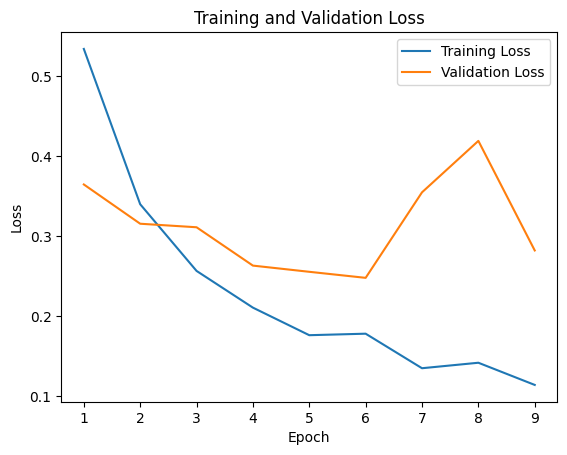

In [167]:
# Training with masking
# Define model, dataset, and dataloaders
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLPBinaryClassifier() 
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 3
print(weight2)

class_weights = torch.tensor([1, weight2]).to(device)  # Move to device
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, masks, labels in train_loader:  # Include masks in data loader
        inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

        # Forward pass with masks
        outputs = model(inputs, masks).squeeze()  # Apply mask

        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]

        # Apply class weights
        loss = (loss * weights).mean()  # Weight the loss

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, masks, labels in val_loader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)

            # Forward pass with masks
            outputs = model(inputs, masks).squeeze()  # Apply mask

            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]
            # Apply class weights
            loss = (loss * weights).mean()  # Weight the loss

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

12.363009592326138
Epoch 1/100, Train Loss: 0.3728, Validation Loss: 1.0997
Epoch 2/100, Train Loss: 0.2467, Validation Loss: 0.8074
Epoch 3/100, Train Loss: 0.2209, Validation Loss: 0.9490
No improvement in validation loss for 1 epoch(s).
Epoch 4/100, Train Loss: 0.2023, Validation Loss: 1.1002
No improvement in validation loss for 2 epoch(s).
Epoch 5/100, Train Loss: 0.1939, Validation Loss: 0.8228
No improvement in validation loss for 3 epoch(s).
Early stopping at epoch 5. Best Validation Loss: 0.8074


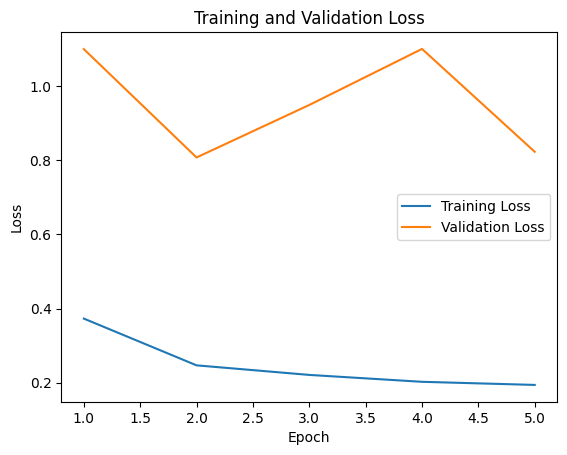

In [421]:
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 6
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
num_epochs = 100
patience = 3  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

24.196596244131456
Epoch 1/100, Train Loss: 0.5478, Validation Loss: 1.5817
Epoch 2/100, Train Loss: 0.3673, Validation Loss: 1.1470
Epoch 3/100, Train Loss: 0.3333, Validation Loss: 1.1644
No improvement in validation loss for 1 epoch(s).
Epoch 4/100, Train Loss: 0.3067, Validation Loss: 1.0968
Epoch 5/100, Train Loss: 0.2898, Validation Loss: 1.0914
Epoch 6/100, Train Loss: 0.2772, Validation Loss: 1.3000
No improvement in validation loss for 1 epoch(s).
Epoch 7/100, Train Loss: 0.2673, Validation Loss: 1.7353
No improvement in validation loss for 2 epoch(s).
Epoch 8/100, Train Loss: 0.2559, Validation Loss: 1.2219
No improvement in validation loss for 3 epoch(s).
Epoch 9/100, Train Loss: 0.2410, Validation Loss: 1.2488
No improvement in validation loss for 4 epoch(s).
Epoch 10/100, Train Loss: 0.2372, Validation Loss: 2.0159
No improvement in validation loss for 5 epoch(s).
Early stopping at epoch 10. Best Validation Loss: 1.0914
Loaded best model with lowest validation loss.


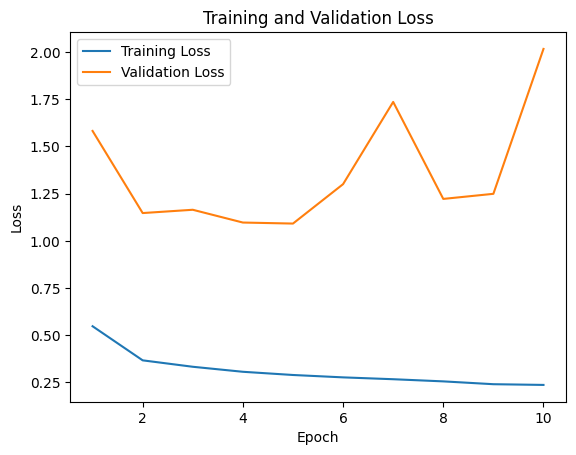

In [446]:
# Use this one
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy

# Define model, dataset, and dataloaders
model = MLPBinaryClassifier()
train_dataset = MLPDataset(us_X_train, us_y_train)
val_dataset = MLPDataset(us_X_test, us_y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define loss function and optimizer
num_positives = us_y_train.sum()
num_negatives = len(us_y_train) - num_positives
weight2 = num_negatives / num_positives / 3
print(weight2)
class_weights = torch.tensor([1, weight2])  # Example class weights
criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training settings
num_epochs = 100
patience = 5  # Number of epochs to wait for improvement
best_val_loss = float('inf')
patience_counter = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store best model
best_model_wts = copy.deepcopy(model.state_dict())

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        weights = class_weights[labels.long()]  # Apply class weights
        loss = (loss * weights).mean()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            weights = class_weights[labels.long()]  # Apply class weights
            loss = (loss * weights).mean()

            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    # Early stopping and saving best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset the counter if validation improves
        best_model_wts = copy.deepcopy(model.state_dict())  # Save best model
    else:
        patience_counter += 1
        print(f"No improvement in validation loss for {patience_counter} epoch(s).")
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Validation Loss: {best_val_loss:.4f}")
            break

# Load the best model after training
model.load_state_dict(best_model_wts)
print("Loaded best model with lowest validation loss.")

# Plot training and validation losses
import matplotlib.pyplot as plt
epochs_x = range(1, len(train_losses) + 1)
plt.plot(epochs_x, train_losses, label="Training Loss")
plt.plot(epochs_x, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


#### Evaluation

In [168]:
# Test set evaluation with masking
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, masks, labels in test_loader:
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs, masks).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

Precision on test set: 0.2118
Recall on test set: 0.7821
F1 score on test set: 0.3333


In [452]:
# Test set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
test_dataset = MLPDataset(us_X_test, us_y_test)  
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)

        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
all_predicted_outputs = np.array(all_predicted_outputs)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on test set: {precision:.4f}")
print(f"Recall on test set: {recall:.4f}")
print(f"F1 score on test set: {f1:.4f}")

Precision on test set: 0.2084
Recall on test set: 0.9057
F1 score on test set: 0.3388


In [462]:
# Get Tang polygons intersection 
#test_dataAZNV = dataAZNV.reset_index(drop=True).loc[aznv_test_idx].reset_index(drop = True) # get just test TX

# Get intersecting test TX 
ga_tang_index = gpd.sjoin(dataGA, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index.to_list()
print(len(ga_tang_index))
print(gpd.sjoin(dataGA, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry')['mine'].sum())

# Filter list
tang_ga_X_test = ga_X_train[ga_tang_index]
tang_ga_y_test = ga_y_train[ga_tang_index]
print(len(tang_ga_y_test))
print(tang_ga_y_test.sum())

212
146
212
6


In [285]:
# Get Tang polygons intersection 
test_dataAZNV = dataAZNV.reset_index(drop=True).loc[aznv_test_idx].reset_index(drop = True) # get just test TX

# Get intersecting test TX 
aznv_tang_index = gpd.sjoin(test_dataAZNV, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index

# Filter list
tang_aznv_X_test = aznv_X_test[aznv_tang_index]
tang_aznv_y_test = aznv_y_test[aznv_tang_index]
print(tang_aznv_y_test.sum())

# Get Tang polygons intersection 
test_dataGA = dataGA.reset_index(drop=True).loc[ga_test_idx].reset_index(drop = True) # get just test TX

# Get intersecting test TX 
ga_tang_index = gpd.sjoin(test_dataGA, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index

# Filter list
tang_ga_X_test = ga_X_test[ga_tang_index]
tang_ga_y_test = ga_y_test[ga_tang_index]
print(tang_ga_y_test.sum())


# Get Tang polygons intersection 
test_dataMN = dataMN.reset_index(drop=True).loc[mn_test_idx].reset_index(drop = True) # get just test TX

# Get intersecting test TX 
mn_tang_index = gpd.sjoin(test_dataMN, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index

# Filter list
tang_mn_X_test = mn_X_test[mn_tang_index]
tang_mn_y_test = mn_y_test[mn_tang_index]
print(tang_mn_y_test.sum())

# Get Tang polygons intersection 
test_dataTX = dataTX.reset_index(drop=True).loc[tx_test_idx].reset_index(drop = True) # get just test TX

# Get intersecting test TX 
tx_tang_index = gpd.sjoin(test_dataTX, mine_poly, how = 'inner', predicate = 'intersects').drop_duplicates('geometry').index

# Filter list
tang_tx_X_test = tx_X_test[tx_tang_index]
tang_tx_y_test = tx_y_test[tx_tang_index]
print(tang_tx_y_test.sum())

1
0
0
0


In [427]:
# Visually inspect
def CreateShapefile(gdf, idx, predictions, filename):
    #filtered_gdf = gdf[idx]
    predictions_gdf = gpd.GeoDataFrame(predictions, geometry = gdf.geometry, columns = ['mine'], crs = '4326')
    print(predictions_gdf)
    file_name = f'data/{filename}.shp'
    predictions_gdf.to_file(file_name)

    return

In [448]:
# Export to shapefile to inspect results
CreateShapefile(dataGA, ga_train_idx, all_predictions, 'ga_preds_0')

      mine                                           geometry
0      0.0  POLYGON ((-84.3283 32.23028, -84.33726 32.2520...
1      0.0  POLYGON ((-84.33726 32.25202, -84.34622 32.273...
2      1.0  POLYGON ((-84.41103 32.36071, -84.42004 32.382...
3      1.0  POLYGON ((-84.42004 32.38246, -84.42906 32.404...
4      1.0  POLYGON ((-84.46698 32.42596, -84.47602 32.447...
...    ...                                                ...
1928   1.0  POLYGON ((-83.24571 32.68722, -83.25471 32.709...
1929   0.0  POLYGON ((-83.27463 32.68722, -83.28363 32.709...
1930   0.0  POLYGON ((-83.26563 32.66544, -83.27463 32.687...
1931   0.0  POLYGON ((-83.29455 32.66544, -83.30355 32.687...
1932   0.0  POLYGON ((-83.28556 32.64365, -83.29455 32.665...

[1933 rows x 2 columns]


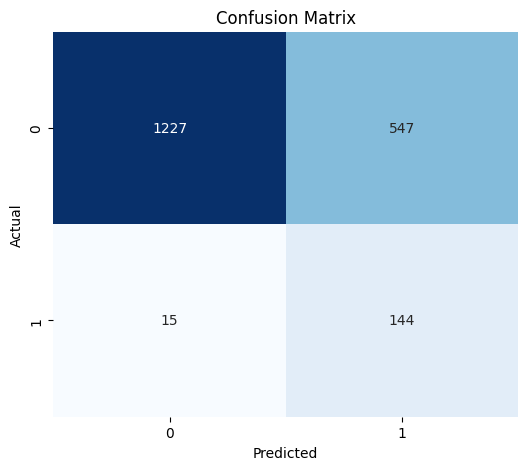

tpr: 0.8050314465408805
threshold: 0.5979203581809998


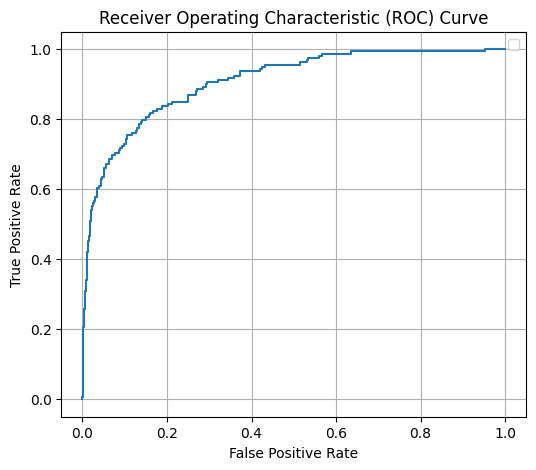

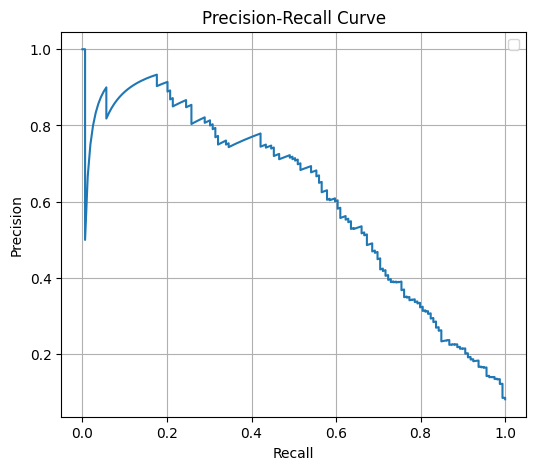

recall: 0.9119496855345912
threshold: 0.3285521864891052


In [461]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

import seaborn as sns

fpr, tpr, thresholds = sklearn.metrics.roc_curve(all_ground_truths, all_predicted_outputs)

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

# Plot 1: Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot 2: ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()

fpr_max = 0.15
print(f'tpr: {tpr[len(fpr[fpr < fpr_max])-1]}')
print(f'threshold: {thresholds[len(fpr[fpr < fpr_max])-1]}')


# Plot 3: Precision-Recall Curve
precision, recall, pr_thresholds = sklearn.metrics.precision_recall_curve(all_ground_truths, all_predicted_outputs)

plt.figure(figsize=(6, 5))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


precision_max = 0.2
print(f'recall: {recall[len(precision[precision < precision_max])-1]}')
print(f'threshold: {pr_thresholds[len(precision[precision < precision_max])-1]}')

(array([38., 33., 18., 32., 24., 34., 32., 26., 29., 42.]),
 array([0.50181729, 0.54882669, 0.59583604, 0.64284545, 0.6898548 ,
        0.73686421, 0.78387362, 0.83088297, 0.87789237, 0.92490172,
        0.97191113]),
 <BarContainer object of 10 artists>)

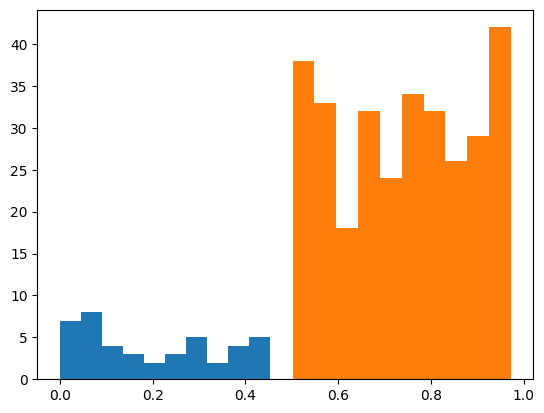

In [63]:
# Inspect false negatives
positives = all_predicted_outputs[all_ground_truths == 1]
plt.hist(positives[positives <= 0.5])

# Inspect false positives
negatives = all_predicted_outputs[all_ground_truths == 0]
plt.hist(negatives[negatives > 0.5])


In [433]:
# Train set evaluation
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, labels in train_eval_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.2541
Recall on train set: 0.7500
F1 score on train set: 0.3796


In [144]:
# Train set evaluation with masking
model.eval()
criterion = nn.BCELoss(reduction='mean') 
train_eval_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)  # Batch size = 1 for per-sample evaluation

prediction_losses = []
all_ground_truths = []
all_predictions = []
all_predicted_outputs = []

for inputs, masks, labels in train_eval_loader:
    inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
    
    # Run inference (no gradients needed for inference)
    with torch.no_grad():
        predicted_outputs = model(inputs, masks).squeeze()  # Predicted probability
        labels = labels.squeeze()
        predictions = (predicted_outputs > 0.5).float()  # Binary predictions (threshold at 0.5)
        
        # Compute loss
        loss = criterion(predicted_outputs, labels)
        prediction_losses.append(loss.item())
        all_predicted_outputs.append(predicted_outputs)
        
        # Collect results
        all_predictions.append(predictions)
        all_ground_truths.append(labels)

# Convert to numpy arrays for metric computation
all_predictions = np.array(all_predictions)
all_ground_truths = np.array(all_ground_truths)
prediction_losses = np.array(prediction_losses)

# Compute metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_ground_truths, all_predictions, average='binary')
recall = recall_score(all_ground_truths, all_predictions, average='binary')
f1 = f1_score(all_ground_truths, all_predictions, average='binary')

print(f"Precision on train set: {precision:.4f}")
print(f"Recall on train set: {recall:.4f}")
print(f"F1 score on train set: {f1:.4f}")

Precision on train set: 0.4612
Recall on train set: 0.8788
F1 score on train set: 0.6049


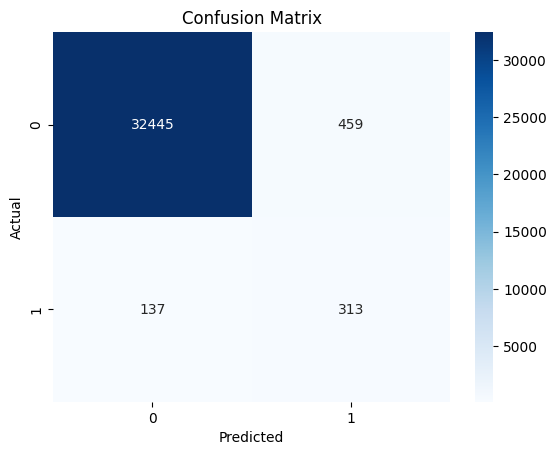

In [1638]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = sklearn.metrics.confusion_matrix(all_ground_truths, all_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [437]:
print(np.median(prediction_losses))
print(np.mean(prediction_losses))
print(np.min(prediction_losses))
print(np.max(prediction_losses))

len(prediction_losses[prediction_losses > 1])

0.04145786166191101
0.2095401255002612
0.00043046241626143456
4.222797393798828


TypeError: '>' not supported between instances of 'list' and 'int'

In [126]:
# For training predictions, find negatives that are high loss
negatives_idx = []
high_loss_negs_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 0:
        negatives_idx.append(i)

for i in range(len(negatives_idx)):
    if prediction_losses[negatives_idx[i]] > 1.2:
        high_loss_negs_idx.append(negatives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_negs_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_negs_idx, axis = 0)
print(len(us_y_train))


32741
32653
32741
32653


In [434]:
# For training predictions, find positives that are high loss

# high loss positives are where model is certain it's positive but it's negative, bc it was told this was positive
positives_idx = []
high_loss_pos_idx = []
for i in range(len(all_predictions)):
    if all_predictions[i] == 1:
        positives_idx.append(i)

for i in range(len(positives_idx)):
    if prediction_losses[positives_idx[i]] > 1:
        high_loss_pos_idx.append(positives_idx[i])

# Drop high_loss_negs_idx from us_X_train and us_y_train
print(len(us_X_train))
us_X_train = np.delete(us_X_train, high_loss_pos_idx, axis = 0)
print(len(us_X_train))

print(len(us_y_train))
us_y_train = np.delete(us_y_train, high_loss_pos_idx, axis = 0)
print(len(us_y_train))

41799
40975
41799
40975
